# Piecewise Deterministic Markov Processes and Jump Diffusion Equations

In [2]:
import diffrax as dfx
import jax
import jax.numpy as jnp
import jumpax as jx
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def plot_solution(sol):
    # First, get the jump points
    mask = jnp.isfinite(sol.ts)
    jump_ts = np.array(sol.ts[mask], dtype=float)
    jump_us = np.array(sol.us[mask, 0], dtype=float)

    plt.figure()

    dense_ts_all = sol.dense["dense_ts"]
    dense_us_all = sol.dense["dense_us"]

    full_ts = []
    full_us = []

    # Process each segment between jumps
    for i in range(dense_ts_all.shape[0]):
        segment_ts = dense_ts_all[i]
        segment_us = dense_us_all[i].squeeze()

        # Filter out inf values
        valid_mask = np.isfinite(segment_ts)
        if np.any(valid_mask):
            t_seg = np.array(segment_ts[valid_mask], dtype=float)
            u_seg = segment_us[valid_mask]
            u_seg = np.array(u_seg, dtype=float)

            full_ts.extend(t_seg)
            full_us.extend(u_seg)

            if i < len(jump_ts) - 2:
                jump_time = t_seg[-1]
                post_jump_value = jump_us[i + 1]
                full_ts.append(jump_time)
                full_us.append(post_jump_value)

    if full_ts:
        plt.plot(full_ts, full_us, "b-", linewidth=1.0, label="Trajectory")

    plt.xlabel("Time")
    plt.ylabel("State")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    plt.show()

    return jump_ts, jump_us

In [8]:
t0, t1 = 0.0, 10.0
u0 = jnp.array([0.2])
save_dense = jx.Save(states=True, reaction_counts=True, dense=True)


def ode_fn(t, y, args):
    # Exponential growth between jumps
    return y


def halving_affect(t, u, args):
    halved = u.at[0].set(0.5 * u[0])
    return jnp.stack([halved], axis=0)


halve_affect = jx.StatelessAffect(halving_affect)

## Constant-Rate Jump

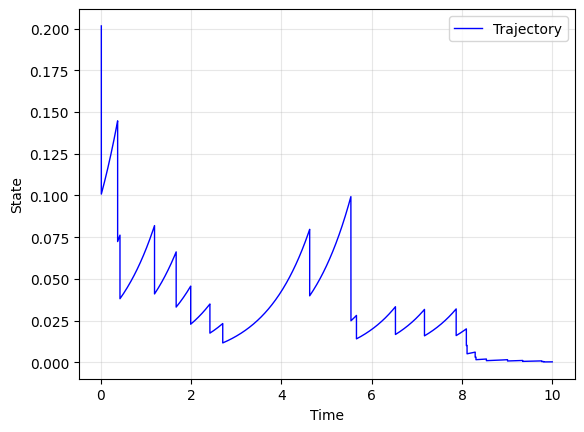

Reaction counts: [24]
Steps taken: 25


In [11]:
rate_const = lambda t, u, args: jnp.array([2.0])
const_jump = jx.ConstantRateJump(rate_const, halve_affect)

hybrid_solver = jx.HybridSSA(ode_fn, solver=dfx.Tsit5(), dt0=1e-2, max_steps=1000)
sol_const = jx.solve(
    const_jump,
    hybrid_solver,
    save_dense,
    u0,
    t0=t0,
    t1=t1,
    args=None,
    key=jax.random.key(0),
)

plot_solution(sol_const)
print("Reaction counts:", sol_const.counts)
print("Steps taken:", sol_const.stats["num_steps"].item())

## Variable-Rate Jump

Now the rate equals the current state value. The rate evolves continuously,
so we switch to `HazardSSA`, which integrates the hazard function alongside
the ODE using Diffrax.

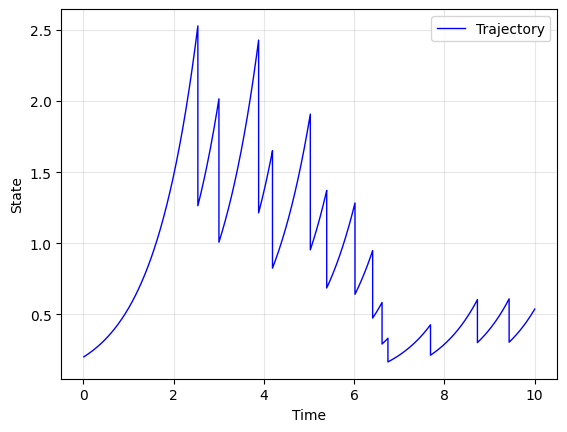

Reaction counts: [13]
Steps taken: 14


In [13]:
rate_var = lambda t, u, args: jnp.array([u[0]])
var_jump = jx.VariableRateJump(rate_var, halve_affect)

hazard_solver = jx.HazardSSA(ode_fn, solver=dfx.Tsit5(), dt0=1e-2, max_steps=1000)
sol_var = jx.solve(
    var_jump,
    hazard_solver,
    save_dense,
    u0,
    t0=t0,
    t1=t1,
    args=None,
    key=jax.random.key(0),
)

plot_solution(sol_var)
print("Reaction counts:", sol_var.counts)
print("Steps taken:", sol_var.stats["num_steps"].item())

## Multiple Jumps

We mix the constant and variable channels by stacking their rates and affects
into a single `VariableRateJump`. Each jump channel halves the state.

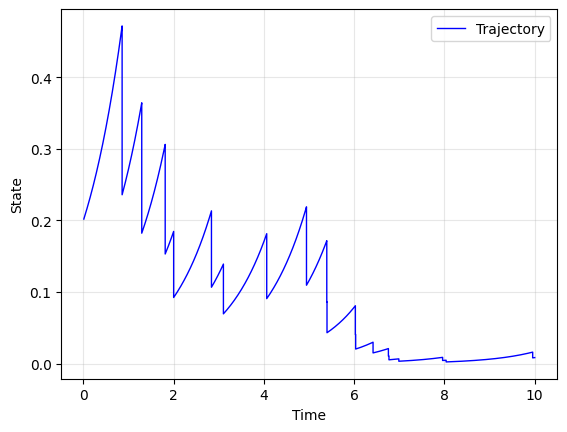

Reaction counts: [16  3]
Steps taken: 20


In [15]:
def rate_multi(t, u, args):
    return jnp.array([2.0, u[0]])


def affect_multi(t, u, args):
    halved = u.at[0].set(0.5 * u[0])
    return jnp.stack([halved, halved], axis=0)


multi_jump = jx.VariableRateJump(rate_multi, jx.StatelessAffect(affect_multi))

hazard_multi_solver = jx.HazardSSA(ode_fn, solver=dfx.Tsit5(), dt0=1e-2, max_steps=1000)
sol_multi = jx.solve(
    multi_jump,
    hazard_multi_solver,
    save_dense,
    u0,
    t0=t0,
    t1=t1,
    args=None,
    key=jax.random.key(4),
)

plot_solution(sol_multi)
print("Reaction counts:", sol_multi.counts)
print("Steps taken:", sol_multi.stats["num_steps"].item())

## Jump Diffusion

Finally we add multiplicative noise.

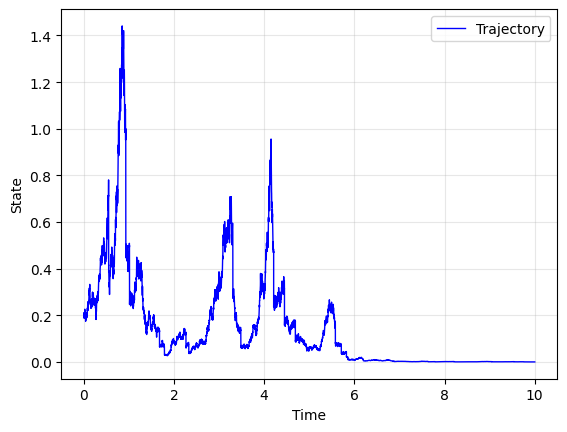

Reaction counts: [26  1]
Steps taken: 28


In [18]:
def drift(t, y, args):
    return y


def diffusion(t, y, args):
    return y[:, None]


hazard_sde = jx.HazardSSA(
    drift, solver=dfx.EulerHeun(), dt0=1e-3, diffusion_fn=diffusion, max_steps=1000
)

key = jax.random.key(42)
sol_diff = jx.solve(
    multi_jump,
    hazard_sde,
    save_dense,
    u0,
    t0=t0,
    t1=t1,
    args=None,
    key=key,
)

plot_solution(sol_diff)
print("Reaction counts:", sol_diff.counts)
print("Steps taken:", sol_diff.stats["num_steps"].item())